# Calculate the mean value of the USD-EUR

In [1]:
import pandas as pd
import numpy as np
import json
import datetime
import pickle
import functions as fn
import matplotlib.pyplot as plt
%matplotlib inline
import requests

## Select wanted exchange rate

In [2]:
exchange_currency = input()

CNY


In [3]:
desired_currency = input()

USD


## Import data to calculate the exchange rate

In [4]:
#Retrieving my api keys information to access the Alpha Advantage API.
keys = fn.get_keys("/Users/jjherranzsarrion/.secret/alphaadvantage.json")
api_key = keys['api_key']

In [5]:
# Get the fx rate from Alpha Advantage 
response_json = fn.get_fx_rates(api_key, exchange_currency, desired_currency)

## Graphing the exchange rate

In [6]:
response_df = fn.get_adjusted_rate(response_json)

In [7]:
response_df[-1:]['Adj Close Price'][0]

0.1414

In [8]:
# Calculate 30 Day Moving Average, Std Deviation, Upper Band and Lower Band
response_bb_df = fn.get_bollinger_bands(response_df)

In [50]:
# Retrieve todays date
today = datetime.date.today()

In [49]:
today.replace(day=1)

datetime.date(2019, 10, 1)

In [48]:
datetime.timedelta(days=1)

datetime.timedelta(1)

In [35]:
print((today.replace(day=1) - datetime.timedelta(days=1)).replace(day=today.day).strftime("%Y-%m-%d"))

2019-09-14


In [52]:
def get_graphical_view(response_df, exchange_currency, desired_currency, today):
    """Function that returns a graphic view of the exchange rate in question
    and the corresponding bollinger bands."""
    # We only want to show the previous month, therefore subset the dataframe
    one_month_ago = (today.replace(day=1) - datetime.timedelta(days=1)).replace(day=today.day).strftime("%Y-%m-%d")
    print(one_month_ago)
    date_15_days_ago = (today - datetime.timedelta(days=15)).strftime("%Y-%m-%d")
    response_df = response_df.loc[(response_df.index >= one_month_ago) & (response_df.index <= today.strftime("%Y-%m-%d"))]
    close = response_bb_df[-1:]['Adj Close Price']
    
    # set style, empty figure and axes
    fig = plt.figure(figsize=(10,5), facecolor='w')
    ax = fig.add_subplot(111)
    
    
    # Get index values for the X axis for exchange rate DataFrame
    x_axis = response_df.index
    
    # Plot shaded 21 Day Bollinger Band for exchange rate
    #ax.fill_between(x_axis, response_df['Upper Band'], response_df['Lower Band'], color='white')
    
    # Plot Adjust Closing Price and Moving Averages
    ax.plot(x_axis, response_df['Adj Close Price'], color='blue', lw=2)
    #ax.plot(x_axis, response_df['30 Day MA'], color='black', lw=2)
    ax.plot(x_axis, response_df['Upper Band'], color='green', lw=2, )
    ax.plot(x_axis, response_df['Lower Band'], color='red', lw=2)
    ax.set_xticks([one_month_ago, date_15_days_ago, today.strftime("%Y-%m-%d")])
    ax.yaxis.tick_right()
    ax.set_facecolor('#ffffff')
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
 
    
    # Set Title & Show the Image
    # Compare the value of the exchange rate currencies
    compare = response_df.loc[response_df.index == today.strftime("%Y-%m-%d")]
    if compare['Adj Close Price'].values > compare['Upper Band'].values:
        print(f'The {exchange_currency} is strong, consider making your international transaction today.')
    elif compare['Adj Close Price'].values > compare['Lower Band'].values:
        print(f"The {exchange_currency} is currently trading according to its boundaries.")
    else:
        print(f"The {exchange_currency} is weak, consider making your international transaction another day.")
    return response_df

2019-09-15
The CNY is currently trading according to its boundaries.


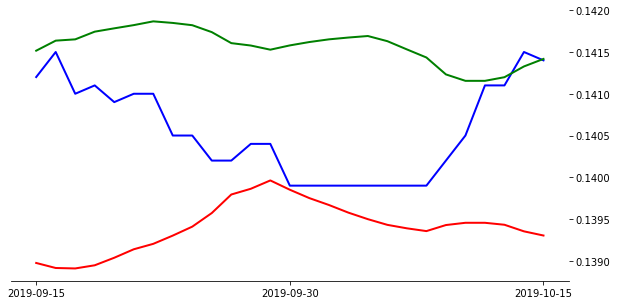

In [53]:
# Return graphic showing the previous monthly history of the exchange rate in question and return recommendation
response_graphic = get_graphical_view(response_bb_df, exchange_currency, desired_currency, today)

There is a problem with the dates on the x axis so check that out

In [121]:
response_bb_df[-1:]['Adj Close Price']

2019-10-04    0.9987
Name: Adj Close Price, dtype: float64

In [126]:
response_bb_df

,Adj Close Price,30 Day MA,30 Day STD,Upper Band,Lower Band
2019-06-11,0.9924,NaN,NaN,NaN,NaN
2019-06-12,0.9952,NaN,NaN,NaN,NaN
2019-06-13,0.9937,NaN,NaN,NaN,NaN
2019-06-14,0.9989,NaN,NaN,NaN,NaN
2019-06-16,0.9983,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2019-09-30,0.9977,0.991570,0.002722,0.997014,0.986126
2019-10-01,0.9931,0.991625,0.002742,0.997109,0.986141
2019-10-02,0.9971,0.991910,0.003002,0.997913,0.985907
2019-10-03,0.9965,0.992080,0.003164,0.998409,0.985751


In [127]:
response_df[-1:]['30 Day MA'][0]

KeyError: '30 Day MA'